# Overview
Generate a downsampled version of an experiment

In [1]:
import os
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

DEBUG: ON


In [2]:
# Install the braingeneers python package
!pip install --quiet git+https://github.com/braingeneers/braingeneerspy.git@d1ee29e

import braingeneers.datasets

  Did not find branch or tag 'd1ee29e', assuming revision or ref.


In [3]:
%%time
# batch = braingeneers.datasets.load_batch("2019-02-15")
batch = braingeneers.datasets.load_batch("2019-02-15")
experiment = braingeneers.datasets.load_experiment(batch["experiments"][0])
print("Found {} data blocks".format(len(experiment["samples"])))

Found 3 data blocks
CPU times: user 44.1 ms, sys: 6.86 ms, total: 51 ms
Wall time: 468 ms


In [4]:
%%time
def min_max_blocks(experiment):
    for i in range(len(experiment["samples"]))[0:debug(1, -1)]:
        X, t, fs = braingeneers.datasets.load_blocks(experiment, i, i+1) 
        step = int(fs / 1000)
        yield np.array([[
            np.amin(X[:,i:min(i + step, X.shape[1]-1)]), 
            np.amax(X[:,i:min(i + step, X.shape[1]-1)])]
          for i in range(0, X.shape[1], step)])

overview = np.concatenate(list(min_max_blocks(experiment)))

CPU times: user 1.7 s, sys: 271 ms, total: 1.97 s
Wall time: 2.13 s


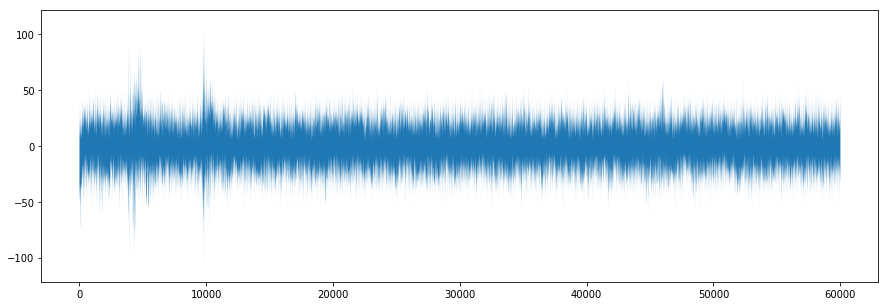

In [5]:
plt.figure(figsize=(15,5))
plt.fill_between(range(0, overview.shape[0]), overview[:,0], overview[:,1])
plt.show()

In [6]:
%%time
def resample_blocks(experiment):
    for i in range(len(experiment["samples"]))[0:debug(1, -1)]:
        X, t, fs = braingeneers.datasets.load_blocks(experiment, i, i+1)
        yield np.array([scipy.signal.resample(X[j,:], X.shape[1] // 1000) for j in range(X.shape[0])])

overview = np.concatenate(list(resample_blocks(experiment)))

CPU times: user 12.5 s, sys: 399 ms, total: 12.9 s
Wall time: 12.9 s


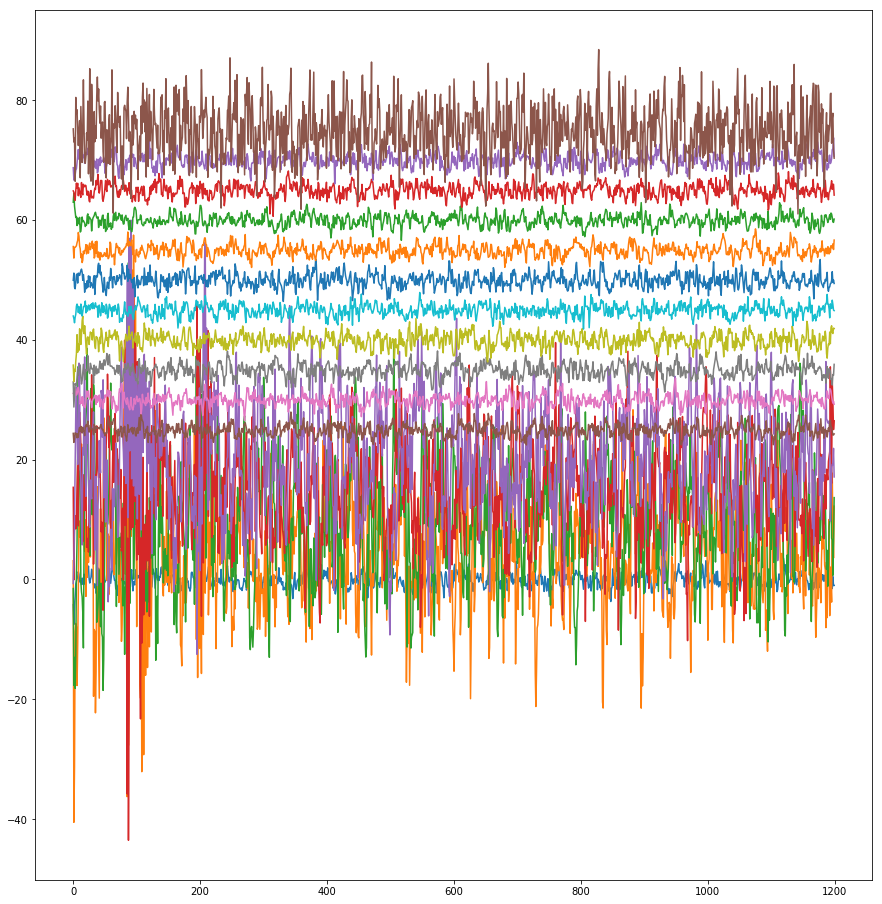

In [7]:
plt.figure(figsize=(15, overview.shape[0]))

for i in range(overview.shape[0]):
    plt.plot(overview[i,:] + i*5)
    
plt.show()

In [ ]:
# import boto3
# session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
# bucket = session.resource("s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket("braingeneers")
  
# path = "archive/features/overviews/{}/{}.npy".format(batch["uuid"], experiment["name"])

# # bucket.Object(path).put(Body=overview.tobytes(), ACL="public-read")

# import tempfile
# src = "/tmp/{}.npy".format(next(tempfile._get_candidate_names()))
# np.save(src, overview)

# bucket.Object(path).upload_file(src, ExtraArgs={"ACL":"public-read"})

In [ ]:
# test = np.load(np.DataSource(None).open("https://s3.nautilus.optiputer.net/braingeneers/{}".format(path), "rb"))

# #         np.load(np.DataSource(None).open("{}/{}".format(get_archive_url(), s["derived"]), "rb"))

In [ ]:
# plt.figure(figsize=(15,5))
# plt.fill_between(range(0, test.shape[0]), test[:,0], test[:,1])
# plt.show()